In [1]:
import numpy as np
from DefineBoundaryFittedGeometries import define_geometry
from ShowMeshesForBoundaryFittedGeometries import show_mesh_for_boundary_fitted_geometries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import grad, functional
from PIL import Image
from channel_bend import *

# Geometry

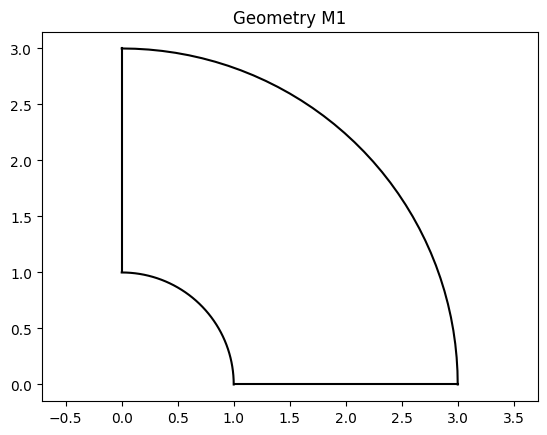

In [2]:
# Choose geometry
geometry = 'M1'

_ = define_geometry(geometry, show_geometry=True)

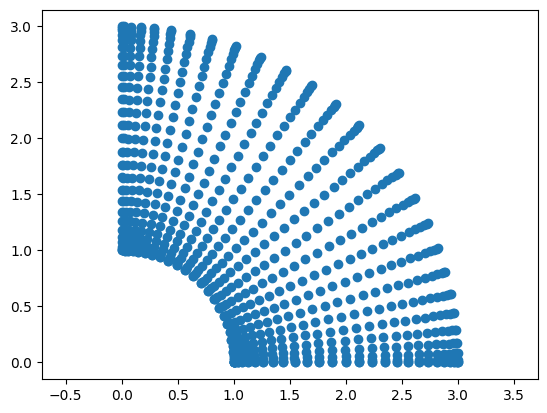

In [3]:
# Show the meshes/points for each geometry. 
physics_xs, physics_ys = show_mesh_for_boundary_fitted_geometries(geometry, print_on_off=False, plot=False)
plt.scatter(physics_xs, physics_ys)
plt.axis('equal')
plt.show()

In [4]:
# Create array of all coordinates. 

physics_xys = np.zeros((physics_xs.shape[0], physics_xs.shape[1], 2))
for i in range(physics_xs.shape[0]):
    physics_xys[i] = np.column_stack((physics_xs[i], physics_ys[i]))

physics_xys = np.reshape(physics_xys, (physics_xs.shape[0]*physics_xs.shape[1], 2))

In [5]:
# Create inlet, outlet and walls arrays. 

def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll

inlet_xys = np.zeros((physics_xs[-1].shape[0], 2))
inlet_xys[:, 0] = physics_xs[-1]
inlet_xys[:, 1] = physics_ys[-1]
inlet_indices = find_sub_list(np.ndarray.tolist(inlet_xys), np.ndarray.tolist(physics_xys))

outlet_xys = np.zeros((physics_xs[0].shape[0], 2))
outlet_xys[:, 0] = physics_xs[0]
outlet_xys[:, 1] = physics_ys[0]
outlet_indices = find_sub_list(np.ndarray.tolist(outlet_xys), np.ndarray.tolist(physics_xys))

right_wall_xs = physics_xs[:, 0]
right_wall_ys = physics_ys[:, 0]

left_wall_xs = physics_xs[:, -1]
left_wall_ys = physics_ys[:, -1]

left_wall_xys = np.zeros((left_wall_xs.shape[0], 2))
left_wall_xys[:, 0] = left_wall_xs
left_wall_xys[:, 1] = left_wall_ys
# left_wall_indices = find_sub_list(np.ndarray.tolist(left_wall_xys), np.ndarray.tolist(physics_xys))

right_wall_xys = np.zeros((right_wall_xs.shape[0], 2))
right_wall_xys[:, 0] = right_wall_xs
right_wall_xys[:, 1] = right_wall_ys
# right_wall_indices = find_sub_list(np.ndarray.tolist(right_wall_xys), np.ndarray.tolist(physics_xys))

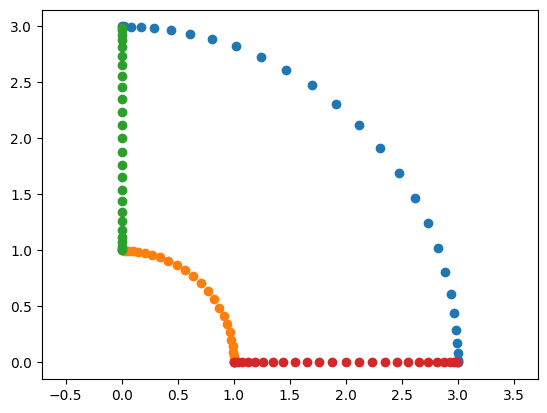

In [12]:
plt.scatter(left_wall_xys[:, 0], left_wall_xys[:, 1])
plt.scatter(right_wall_xys[:, 0], right_wall_xys[:, 1])
plt.scatter(inlet_xys[1:-1, 0], inlet_xys[1:-1, 1])
plt.scatter(outlet_xys[1:-1, 0], outlet_xys[1:-1, 1])
plt.axis('equal')
plt.show()

In [7]:
# Define network architecture.

class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )
    
    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x


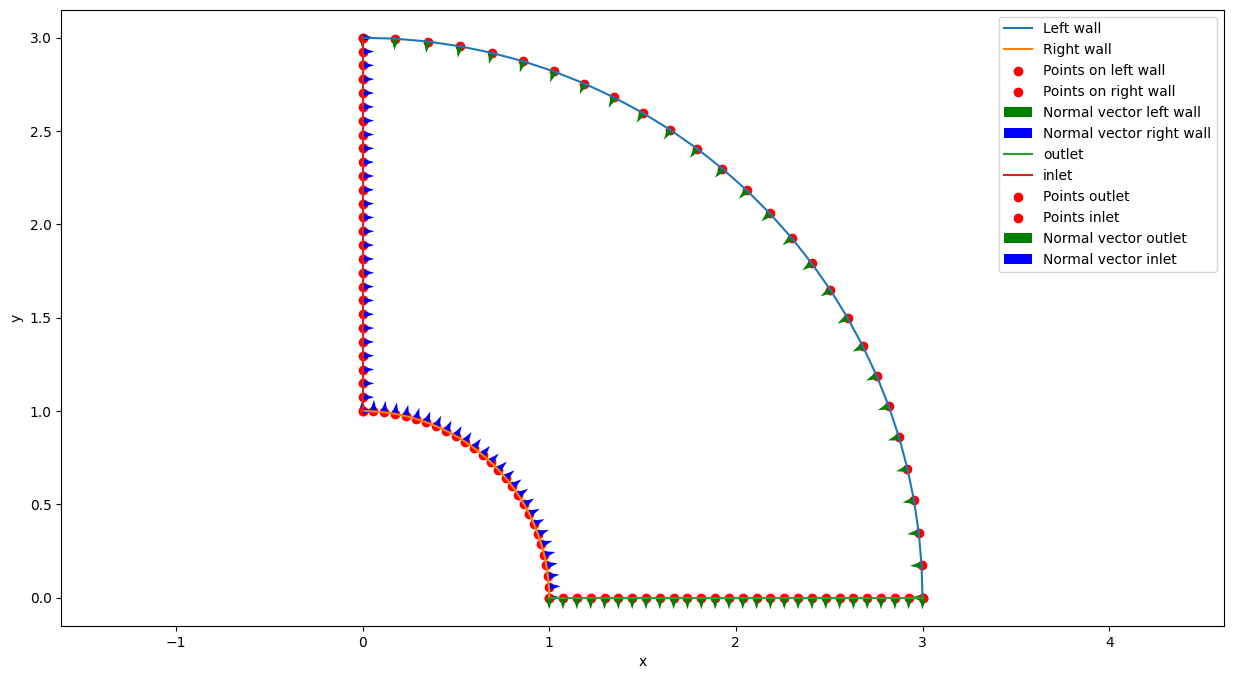

In [8]:
# Calculate normal vectors for the boundary condition, pipe walls.
gam1, _, gam2, _, gam3, _, gam4, _ = define_geometry(geometry, show_geometry=False)

# Choose functions. This changes with choice of geometry (alas).
if geometry == 'M3':
    left_wall_fct = gam3
    right_wall_fct = gam1
    inlet_fct = gam4
    outlet_fct = gam2

if geometry == 'M1':
    left_wall_fct = gam2
    right_wall_fct = gam4
    inlet_fct = gam3
    outlet_fct = gam1

(
    normal_vectors_left,
    normal_vectors_right,
    normal_vectors_inlet,
    normal_vectors_outlet,
) = get_normal_vectors(
    left_wall_fct, right_wall_fct, inlet_fct, outlet_fct, nr_pts=28, show_normals=True
)

Step: 2000
PDE loss, boundary loss, data loss: (tensor(1.8310, grad_fn=<MeanBackward0>), tensor(0.0071, grad_fn=<AddBackward0>), 0)


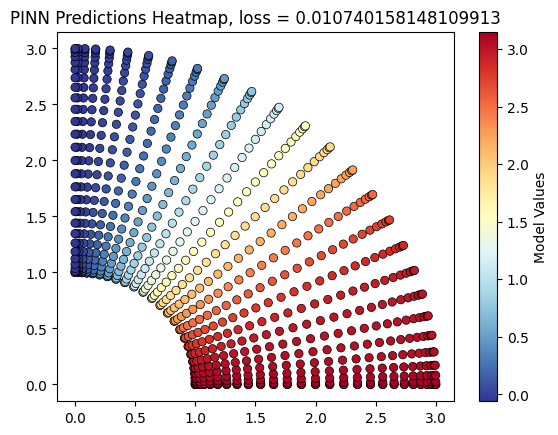

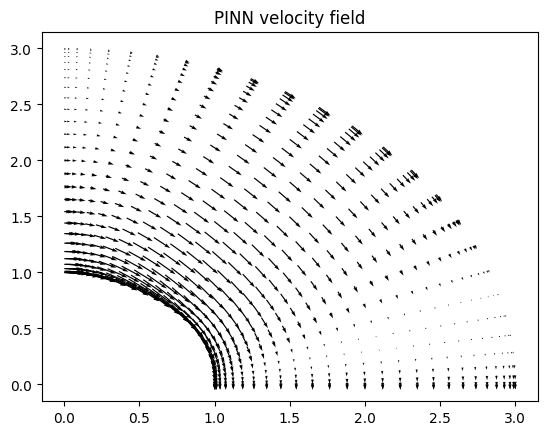

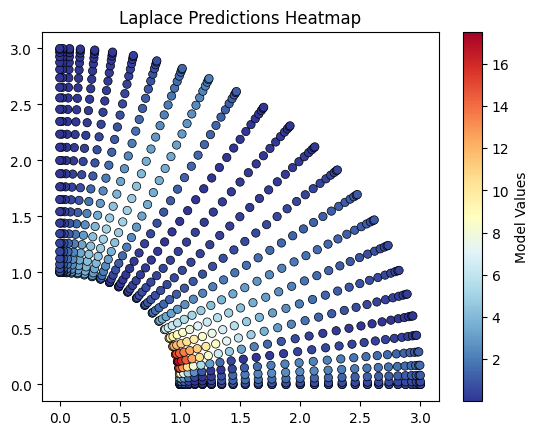

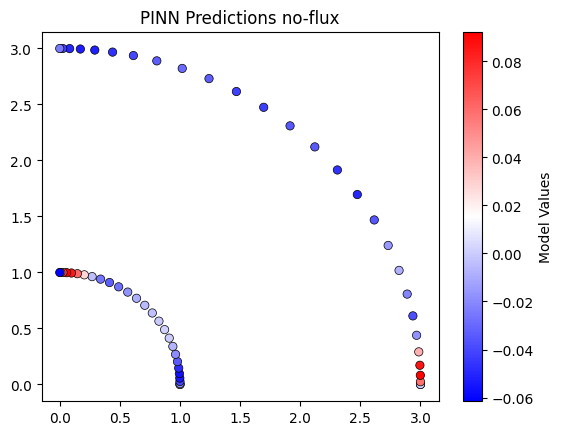

Step: 4000
PDE loss, boundary loss, data loss: (tensor(1.5789, grad_fn=<MeanBackward0>), tensor(0.0018, grad_fn=<AddBackward0>), 0)


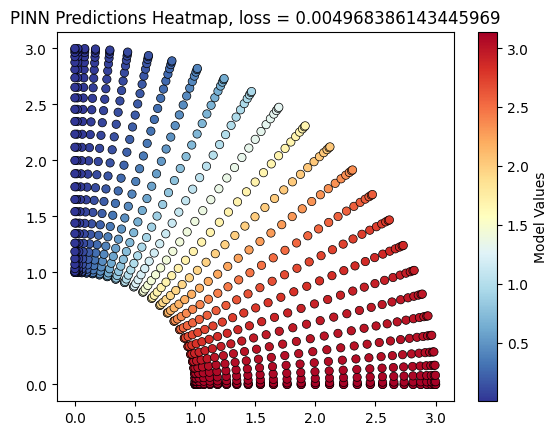

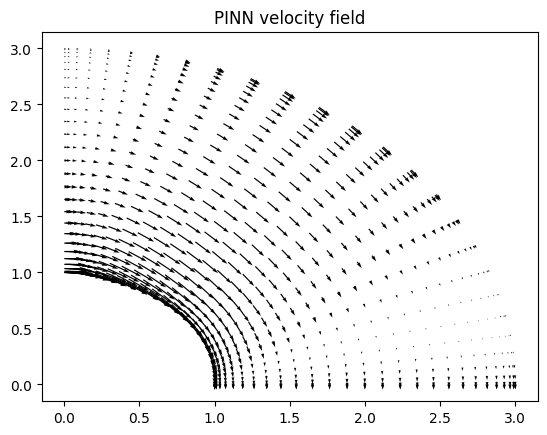

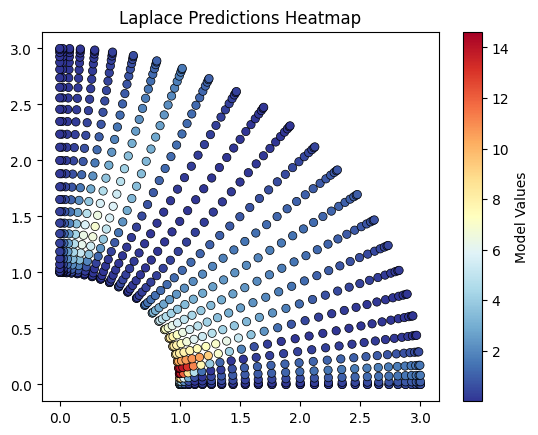

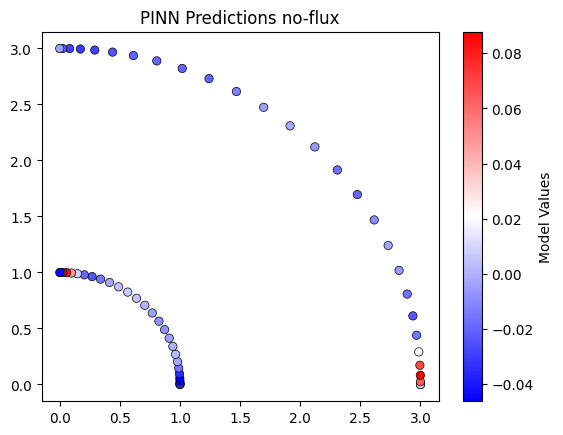

Step: 6000
PDE loss, boundary loss, data loss: (tensor(1.4329, grad_fn=<MeanBackward0>), tensor(0.0012, grad_fn=<AddBackward0>), 0)


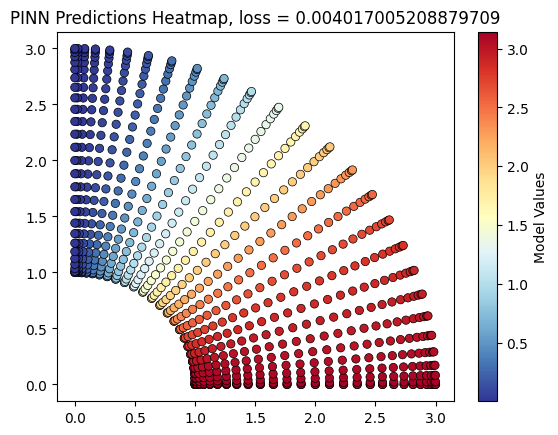

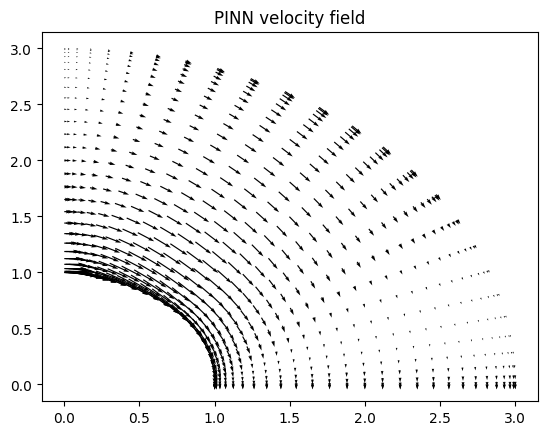

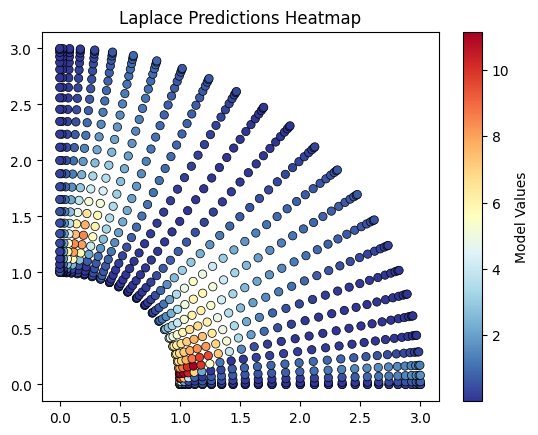

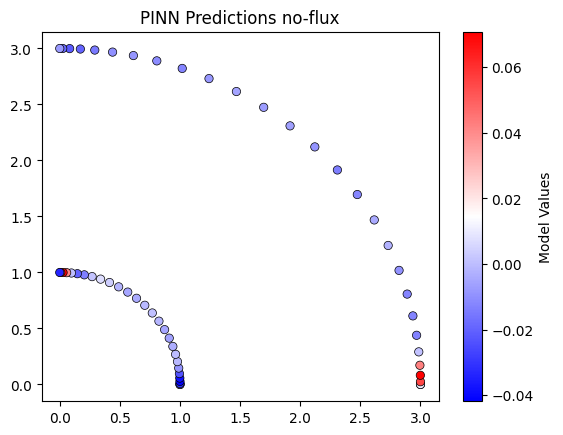

Step: 8000
PDE loss, boundary loss, data loss: (tensor(1.2659, grad_fn=<MeanBackward0>), tensor(0.0009, grad_fn=<AddBackward0>), 0)


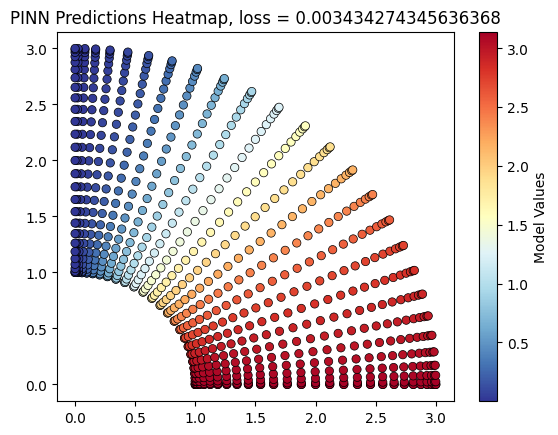

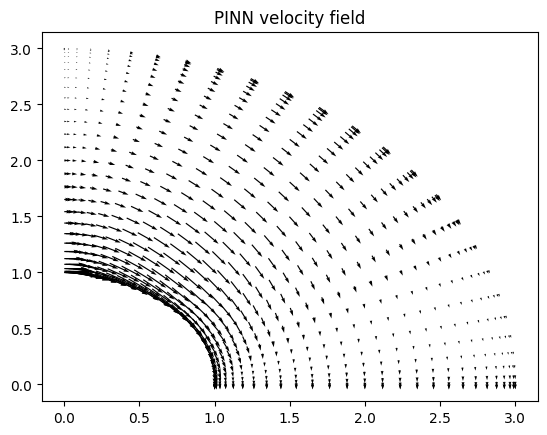

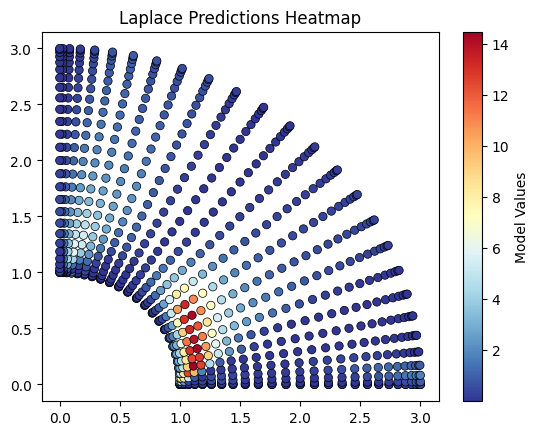

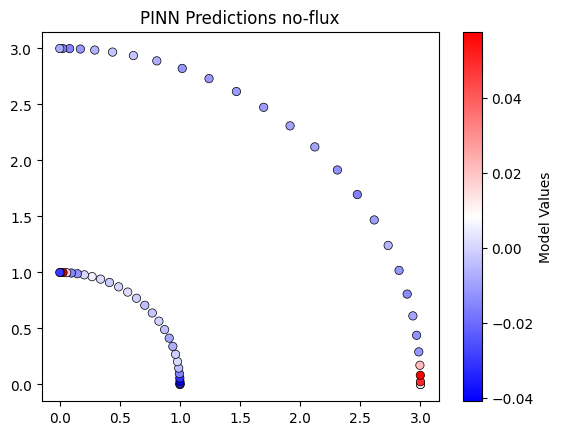

Step: 10000
PDE loss, boundary loss, data loss: (tensor(1.1106, grad_fn=<MeanBackward0>), tensor(0.0007, grad_fn=<AddBackward0>), 0)


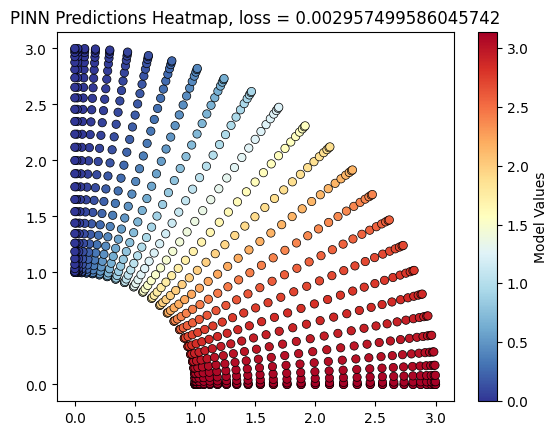

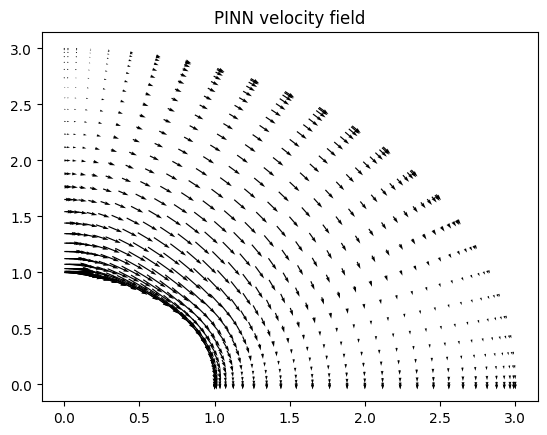

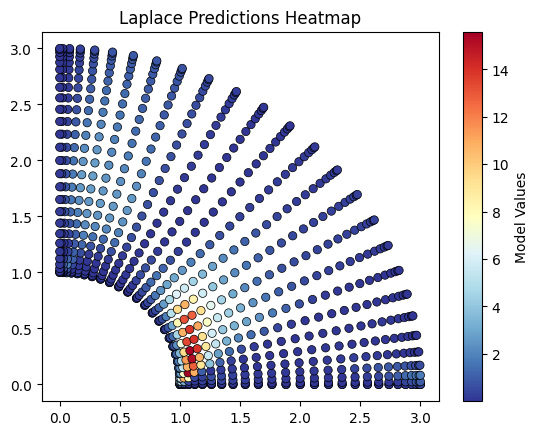

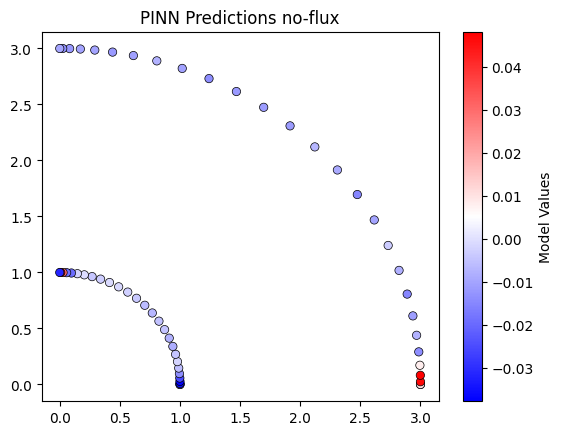

In [9]:
# Create the training loop. 
# Include training data when available or just use physics loss. 
use_data = False
if use_data:
  data_x = torch.tensor(xs_training)
  data_y = torch.tensor(ys_training)

else:
  data_x = None
  data_y = None

# Define same "random" initialization og weights. 
torch.manual_seed(123)

# Define boundary values. 
inlet_value = 0
outlet_value = 3.14
inlet_grad_value = 0.5
outlet_grad_value = 0.5

# Define loss weighting. 
pde_weight = 2*1e-3
boundary_weight = 1.0
data_weight = 1.0

# Convert everything to tensors. 
physics_xys_tensor = torch.tensor(physics_xys, dtype=torch.float32).requires_grad_(True)
inlet_xys_tensor = torch.tensor(inlet_xys, dtype=torch.float32, requires_grad=True)
outlet_xys_tensor = torch.tensor(outlet_xys, dtype=torch.float32, requires_grad=True)
right_wall_xys_tensor = torch.tensor(right_wall_xys, dtype=torch.float32).requires_grad_(True)
left_wall_xys_tensor = torch.tensor(left_wall_xys, dtype=torch.float32).requires_grad_(True)
normal_vectors_left_tensor = torch.tensor(normal_vectors_left, dtype=torch.float32)
normal_vectors_right_tensor = torch.tensor(normal_vectors_right, dtype=torch.float32)
normal_vectors_inlet_tensor = torch.tensor(normal_vectors_inlet, dtype=torch.float32)
normal_vectors_outlet_tensor = torch.tensor(normal_vectors_outlet, dtype=torch.float32)

# Define model.
model = FullyConnected(2, 64, 1)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)
scheduler = StepLR(optimizer2, step_size=2000, gamma=0.95)

for i in range(10000):
  optimizer2.zero_grad()
  # Data loss
  if use_data:
    model_data_values = model(data_xys)
    data_loss = torch.mean((model_data_values - data_values) ** 2) # Mean squared error
  else:
    data_loss = 0

  # Physics loss.
  # get model's results.
  physics_pred_fs = model(physics_xys_tensor)
  grad_f = gradient(physics_pred_fs, physics_xys_tensor)

  df_dx = grad_f[:, 0]
  df_dy = grad_f[:, 1]

  d2f_dx2 = gradient(df_dx, physics_xys_tensor)[:, 0]
  d2f_dy2 = gradient(df_dy, physics_xys_tensor)[:, 1]

  # Define PDE residual. 
  residual_laplace = (d2f_dx2 + d2f_dy2)**2
  pde_residual_loss = torch.mean(residual_laplace)

  # Set up boundary conditions. 
  # Inlet
  inlet_values = torch.full_like(inlet_xys_tensor, fill_value=inlet_value)
  model_inlet_values = model(inlet_xys_tensor)
  
  # inlet_grad_value_dx = torch.full_like(model_inlet_values, fill_value=inlet_grad_value)
  inlet_grad_values = grad_f[inlet_indices[0]:inlet_indices[1], :]

  df_dx_inlet = inlet_grad_values[:, 0]
  df_dy_inlet = inlet_grad_values[:, 1]
  
  inlet_loss = torch.mean((inlet_values - model_inlet_values)**2) + torch.mean((df_dy_inlet-normal_vectors_inlet_tensor[:, 1])**2) + torch.mean((df_dx_inlet[13]-normal_vectors_inlet_tensor[:, 0][13]*inlet_grad_value)**2) 

  # Outlet
  outlet_values = torch.full_like(outlet_xys_tensor, fill_value=outlet_value)
  model_outlet_values = model(outlet_xys_tensor)
  
  # outlet_grad_value_dy = torch.full_like(model_outlet_values, fill_value=outlet_grad_value)*(-1)
  outlet_grad_values = grad_f[outlet_indices[0]:outlet_indices[1], :]

  df_dx_outlet = outlet_grad_values[:, 0]
  df_dy_outlet = outlet_grad_values[:, 1]

  outlet_loss = torch.mean((df_dy_outlet-normal_vectors_outlet_tensor[:, 1]*outlet_grad_value)**2)  + torch.mean((outlet_values[13] - model_outlet_values[13])**2) + torch.mean((df_dx_outlet-normal_vectors_outlet_tensor[:, 0])**2)  

  # Boundary condition on walls. Use zero-flux. 
  right_wall_values = model(right_wall_xys_tensor)
  left_wall_values = model(left_wall_xys_tensor)

  right_wall_grad = grad_f[::28, :]
  left_wall_grad = grad_f[27::28, :]

  flux_left_wall = left_wall_grad[:, 0] * normal_vectors_left_tensor[:, 0] + left_wall_grad[:, 1] * normal_vectors_left_tensor[:, 1]
  flux_right_wall = right_wall_grad[:, 0]  * normal_vectors_right_tensor[:, 0] + right_wall_grad[:, 1] * normal_vectors_right_tensor[:, 1]
  
  left_wall_loss = torch.mean(flux_left_wall**2)
  right_wall_loss = torch.mean(flux_right_wall**2)

  # Compute total boundary loss.
  boundary_loss = inlet_loss + outlet_loss + left_wall_loss + right_wall_loss 

  # Compute total physics loss.
  physics_loss = pde_weight * pde_residual_loss
  
  loss =  pde_weight*pde_residual_loss + boundary_weight*boundary_loss #+ data_weight*data_loss 
  
  loss.backward()
  optimizer2.step()
  scheduler.step()


  # Visualize.
  if (i+1) % 2000 == 0:
    print(f'Step: {i+1}')
    print(f'PDE loss, boundary loss, data loss: {pde_residual_loss, boundary_loss, data_loss}')

    # Show PINNs values. 
    # Detach PIIns values. 
    values_f = physics_pred_fs.detach().numpy()
    values_dx = df_dx.detach().numpy()
    values_dy = df_dy.detach().numpy()
    values_laplace = residual_laplace.detach().numpy()

    # scatter = plt.scatter(physics_xys[:, 0], physics_xys[:, 1,], c=values, norm=norm, cmap='RdYlBu_r', edgecolors='k', linewidths=0.5)
    # scatter = plt.scatter(physics_xys[:, 0], physics_xys[:, 1], c=values_f, cmap='RdYlBu_r', edgecolors='k', linewidths=0.5)
    # plt.colorbar(scatter, label='Model Values')
    # plt.title(f'Step: {i}')
    # plt.axis('equal')
    # plt.show()

    plt.quiver(physics_xys[:, 0], physics_xys[:, 1], values_dx, values_dy)
    plt.title(f"PINN velocity field, step {i}")
    plt.axis('equal')
    plt.show()
    

    # scatter = plt.scatter(physics_xys[:, 0], physics_xys[:, 1], c=values_laplace, cmap='RdYlBu_r', edgecolors='k', linewidths=0.5)
    # plt.colorbar(scatter, label='Model Values')
    # plt.title("Laplace Predictions Heatmap")
    # plt.axis('equal')
    # plt.show()

    # Detach flux values for plotting.
    values_right = flux_right_wall.detach().numpy()
    values_left = flux_left_wall.detach().numpy()
    scatter_right = plt.scatter(right_wall_xys[:, 0], right_wall_xys[:, 1], c=values_right, cmap='bwr', edgecolors='k', linewidths=0.5)
    scatter_left = plt.scatter(left_wall_xys[:, 0], left_wall_xys[:, 1], c=values_left, cmap='bwr', edgecolors='k', linewidths=0.5)

    # Fix interval for heatmap:
    # lower_cutoff = -0.005
    # upper_cutoff = 0.005
    # # # Create a normalization object for values within the specified range
    # norm = Normalize(vmin=lower_cutoff, vmax=upper_cutoff, clip=True)
    # Plot
    # scatter_right = plt.scatter(right_wall_xys[:, 0], right_wall_xys[:, 1], c=values_right, norm=norm, cmap='bwr', edgecolors='k', linewidths=0.5)
    # scatter_left = plt.scatter(left_wall_xys[:, 0], left_wall_xys[:, 1], c=values_left, norm=norm, cmap='bwr', edgecolors='k', linewidths=0.5)

    plt.colorbar(scatter_right, label='Model Values')
    # Set axis labels and plot title
    plt.title("PINN Predictions no-flux")
    plt.show()

In [10]:
# def save_gif_PIL(outfile, files, fps=5, loop=0):
#     "Helper function for saving GIFs"
#     imgs = [Image.open(file) for file in files]
#     imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [11]:
# # create GIF.

# files = []
# starting_point_y = 2
# x = torch.zeros(1, requires_grad=True)
# y = torch.ones(1, requires_grad=True)*starting_point_y
# for i in range(10000):
#     x_value = x.detach().numpy()
#     y_value = y.detach().numpy()
#     plt.quiver(physics_xys[:, 0], physics_xys[:, 1], values_dx, values_dy)
#     plt.scatter(x_value,y_value)
#     plt.title("PINN velocity field")

#     file = "plots/channel_%.8i.png"%(i)
#     plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#     files.append(file)

#     plt.show()

#     dx = torch.ones(1, requires_grad=True)*1e-4
#     dy = torch.ones(1, requires_grad=True)*1e-4
#     step_size = torch.ones(1, requires_grad=True)*1e-1
#     d_dx = (model(torch.tensor([x + dx,y],dtype=torch.float32).requires_grad_(True)) - model(torch.tensor([x,y],dtype=torch.float32).requires_grad_(True)))/dx
#     d_dy = (model(torch.tensor([x,y + dy],dtype=torch.float32).requires_grad_(True)) - model(torch.tensor([x,y],dtype=torch.float32).requires_grad_(True)))/dy
#     x = x + d_dx*step_size
#     y = y + d_dy*step_size
#     if y.item() < 0.0:
#         break

# save_gif_PIL("Channel_pinn.gif", files, fps=20, loop=0)
